In [1]:
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.0/144.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = "DavidSolan0/coverart"
pipe = StableDiffusionPipeline.from_pretrained(
    model_path, torch_dtype=torch.float16
).to(device)
g_cuda = None

g_cuda = torch.Generator(device=device)
seed = 52362
g_cuda.manual_seed(seed)

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
def difussion_image(prompt):
  negative_prompt = ""
  num_samples = 4
  guidance_scale = 7.5
  num_inference_steps = 50
  height = 512
  width = 512

  with autocast("cuda"), torch.inference_mode():
      images = pipe(
          prompt,
          height=height,
          width=width,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_samples,
          num_inference_steps=num_inference_steps,
          guidance_scale=guidance_scale,
          generator=g_cuda,
      ).images

  for img in images:
      display(img)
  print(len(images))
  return images

  0%|          | 0/50 [00:00<?, ?it/s]

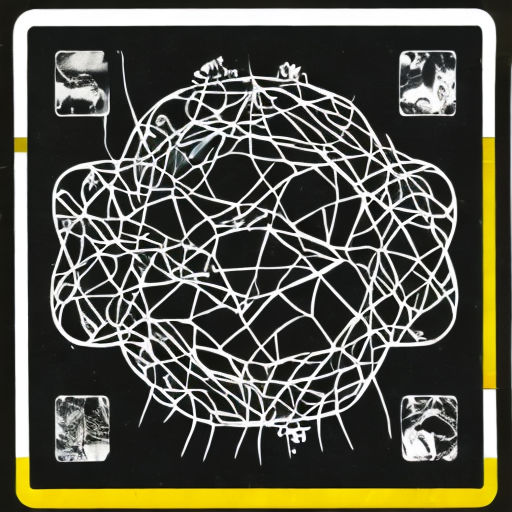

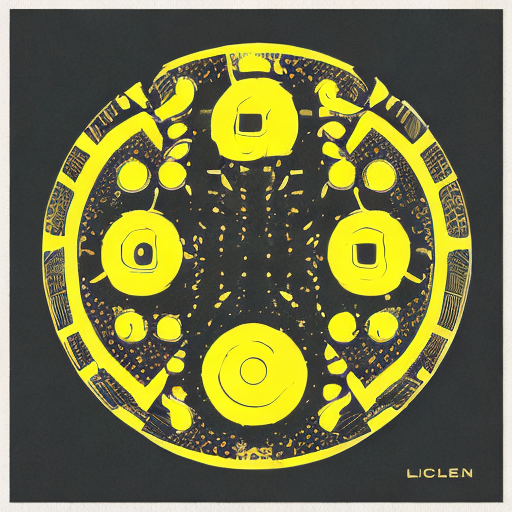

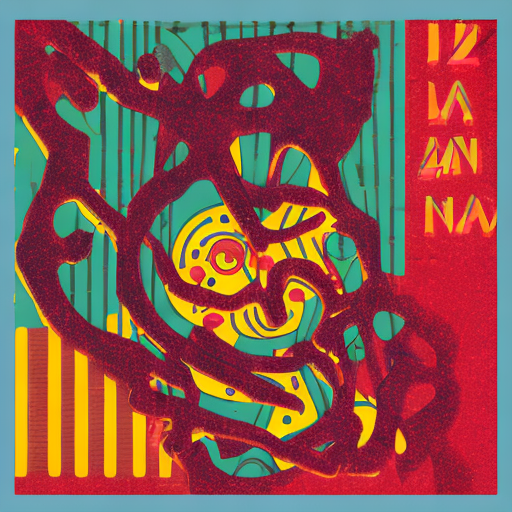

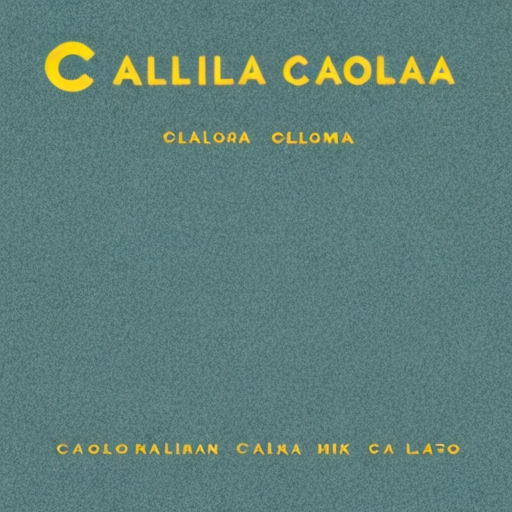

4


In [11]:
pro = "cover album of Generative song, titled in the car (colombia), released in 1990-01-01, by lil cake, with the following music tags latin, male, pop, reggeaton, young"
images_ = difussion_image(pro)

In [6]:
for im in images_:
  print(type(im), type(images_))

<class 'PIL.Image.Image'> <class 'list'>
<class 'PIL.Image.Image'> <class 'list'>
<class 'PIL.Image.Image'> <class 'list'>
<class 'PIL.Image.Image'> <class 'list'>


In [7]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2SU2NSEidnxZZEPkaB4RDClEoum_2oeutAXqt5FJz9LshWBkq

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=9045b530621db9d8a120526af1271e4150757b38c8088dcfb8fa1376f31cd9e2
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [8]:
from PIL import Image
from io import BytesIO

In [9]:
from flask import Flask, Response
from flask_ngrok import run_with_ngrok
import flask
from flask import abort, request

app = flask.Flask(__name__)

run_with_ngrok(app)

@app.route("/", methods=['POST'])
def home():
    prompt = request.get_data(as_text=True)
    image  = difussion_image(prompt)
    display(image)
    print(len(image))
    imagenes_bytes = []
    for imagen in image:
        imagen_bytes = BytesIO()
        imagen.save(imagen_bytes, format='JPEG')  # Ajusta el formato según tus necesidades
        imagen_bytes.seek(0)
        imagenes_bytes.append(imagen_bytes.getvalue())

    # Devolver la lista de imágenes como respuesta
    return Response(response=imagenes_bytes, mimetype='multipart/x-mixed-replace; boundary=frame')
    return image

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://8d60-34-143-202-229.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040
